# CAD integration


Steps:

1) Create the CAD files
2) Create a mesh ([SALOME](https://www.salome-platform.org/), [GMSH](https://gmsh.info/)...)
3) Convert the mesh to XDMF (using [meshio](https://github.com/nschloe/meshio))

In [2]:
import meshio


def convert_med_to_xdmf(
    med_file,
    cell_file="mesh_domains.xdmf",
    facet_file="mesh_boundaries.xdmf",
    cell_type="tetra",
    facet_type="triangle",
):
    """Converts a MED mesh to XDMF
    Args:
        med_file (str): the name of the MED file
        cell_file (str, optional): the name of the file containing the
            volume markers. Defaults to "mesh_domains.xdmf".
        facet_file (str, optional): the name of the file containing the
            surface markers.. Defaults to "mesh_boundaries.xdmf".
        cell_type (str, optional): The topology of the cells. Defaults to "tetra".
        facet_type (str, optional): The topology of the facets. Defaults to "triangle".
    Returns:
        dict, dict: the correspondance dict, the cell types
    """
    msh = meshio.read(med_file)

    correspondance_dict = msh.cell_tags

    cell_data_types = msh.cell_data_dict["cell_tags"].keys()

    for mesh_block in msh.cells:
        if mesh_block.type == cell_type:

            meshio.write_points_cells(
                cell_file,
                msh.points,
                [mesh_block],
                cell_data={"f": [-1 * msh.cell_data_dict["cell_tags"][cell_type]]},
            )
        elif mesh_block.type == facet_type:
            meshio.write_points_cells(
                facet_file,
                msh.points,
                [mesh_block],
                cell_data={"f": [-1 * msh.cell_data_dict["cell_tags"][facet_type]]},
            )

    return correspondance_dict, cell_data_types

In [3]:
correspondance_dict, cell_data_types = convert_med_to_xdmf("task7/mesh.med", cell_file="task7/mesh_domains.xdmf", facet_file="task7/mesh_boundaries.xdmf")

print(correspondance_dict)

{-6: ['tungsten'], -7: ['cu'], -8: ['cucrzr'], -9: ['top_surface'], -10: ['cooling_surface'], -11: ['poloidal_gap'], -12: ['toroidal_gap'], -13: ['bottom']}


In [4]:
import festim as F

my_model = F.Simulation()

my_model.mesh = F.MeshFromXDMF(volume_file="task7/mesh_domains.xdmf", boundary_file="task7/mesh_boundaries.xdmf")

Succesfully load mesh with 106966 cells


In [5]:
tungsten = F.Material(
    id=6,
    D_0=4.1e-7,
    E_D=0.39,
    S_0=1.87e24,
    E_S=1.04,
    thermal_cond=100,
)

copper = F.Material(
    id=7,
    D_0=6.6e-7,
    E_D=0.387,
    S_0=3.14e24,
    E_S=0.572,
    thermal_cond=350,
)

cucrzr = F.Material(
    id=8,
    D_0=3.92e-7,
    E_D=0.418,
    S_0=4.28e23,
    E_S=0.387,
    thermal_cond=350
)

my_model.materials = [tungsten, copper, cucrzr]

In [6]:
heat_flux_top = F.FluxBC(surfaces=9, value=10e6, field="T")
convective_flux_coolant = F.ConvectiveFlux(surfaces=10, h_coeff=7e04, T_ext=323)
implantation_flux_top = F.ImplantationDirichlet(surfaces=9, phi=1.61e22, R_p=9.52e-10, D_0=tungsten.D_0, E_D=tungsten.E_D)
recombination_flux = F.DirichletBC(surfaces=[10, 11, 12, 13], value=0, field=0)

my_model.boundary_conditions = [heat_flux_top, convective_flux_coolant, implantation_flux_top, recombination_flux]

In [7]:
my_model.T = F.HeatTransferProblem(transient=False)

In [36]:
my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    transient=False,
    chemical_pot=True
)

my_model.exports = [F.XDMFExport("T"), F.XDMFExport("solute")]

my_model.initialise()
my_model.run()

Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 7.50 s


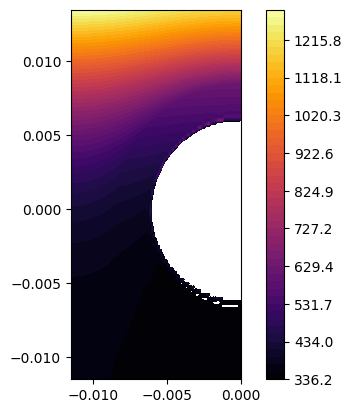

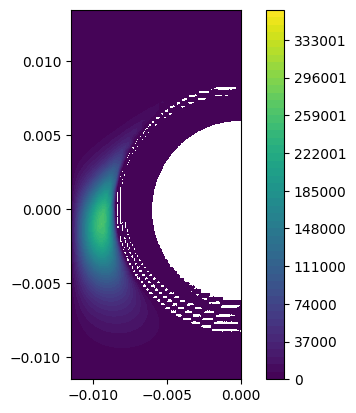

In [37]:
from fenics import UserExpression, plot, FunctionSpace, project, RectangleMesh, Point
import matplotlib.pyplot as plt
import numpy as np

class u_slice(UserExpression):
    def __init__(self, fun):
        self.fun = fun
        super().__init__()

    def eval(self, value, x):
        try:
            value[0] = self.fun(x[0], x[1], 0.00125)
        except RuntimeError:
            value[0] = -1

    def value_shape(self):
        return ()

mesh_2d = RectangleMesh(Point(-0.0115, -0.0115), Point(0, 0.0135), 100, 100)
Vs = FunctionSpace(mesh_2d, "CG", 1)

T_2d = project(u_slice(my_model.T.T), Vs)

min_T = np.min(my_model.T.T.vector().get_local())
max_T = np.max(my_model.T.T.vector().get_local())

CF = plot(T_2d, levels=np.linspace(min_T, max_T, 50), cmap="inferno")
plt.colorbar(CF)
plt.show()


mobile_conc = my_model.h_transport_problem.mobile.solution
c_2d = project(u_slice(mobile_conc), Vs)

max_c = np.max(mobile_conc.vector().get_local())

CF = plot(c_2d, levels=np.linspace(0, max_c, 50), cmap="viridis")
plt.colorbar(CF)
plt.show()
